In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input, Dense, LSTM, GlobalMaxPool1D, GRU, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.preprocessing import StandardScaler

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [0]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [0]:
# Start by doing the WRON|G thing - trying to predict the price itself
series =df['close'].values.reshape(-1,1)

In [0]:
#Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
#let's see if we can use T past values to predict the next value
T=10
D=1
X=[]
Y=[]
N= len(series)

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (619, 10, 1) Y.shape (619, 1)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T,1))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01)
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:])
)

Epoch 1/80
10/10 [==============================] - 0s 40ms/step - loss: 0.1450 - val_loss: 0.4715
Epoch 2/80
10/10 [==============================] - 0s 7ms/step - loss: 0.0278 - val_loss: 0.4179
Epoch 3/80
10/10 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.4081
Epoch 4/80
10/10 [==============================] - 0s 18ms/step - loss: 0.0104 - val_loss: 0.4233
Epoch 5/80
10/10 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.4455
Epoch 6/80
10/10 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.4587
Epoch 7/80
10/10 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.4577
Epoch 8/80
10/10 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.4582
Epoch 9/80
10/10 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.4519
Epoch 10/80
10/10 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.4420
Epoch 11/80
10/10

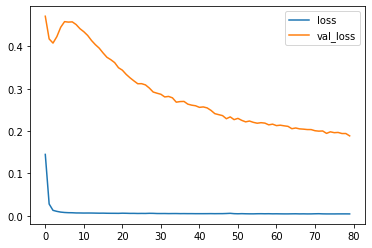

In [0]:
#plot loss
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

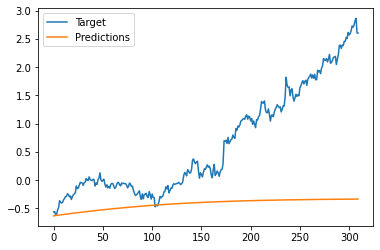

In [0]:
#Multi-Step prediction
validation_predictions=[]
validation_target=Y[-N//2:]

# firts validation unput
last_x = X[-N//2]

while len(validation_predictions)< len(validation_target):
  p = model.predict(last_x.reshape(1,T,1))[0,0]

  #update the predictions list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1]=p


plt.plot(validation_target, label='Target')
plt.plot(validation_predictions, label='Predictions')
plt.legend()


In [0]:
 print(validation_predictions)

[]


In [0]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [0]:
df['PrevClose']=df['close'].shift(1)

In [0]:
#Return calculation
df['Return'] = (df['close']-df['PrevClose']) / df['PrevClose']

In [0]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


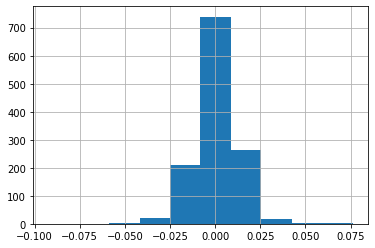

In [0]:
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1,1)

In [0]:
#Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [0]:
series.shape

(1258,)

In [0]:
### build the dataset
#let's see if we can use T past values to predict the next value
T=10
D=1
X=[]
Y=[]
N= len(series)

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T,1))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01)
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 0s 21ms/step - loss: 1.0123 - val_loss: 1.1275
Epoch 2/80
20/20 [==============================] - 0s 15ms/step - loss: 0.9907 - val_loss: 1.1319
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9860 - val_loss: 1.1300
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9897 - val_loss: 1.1343
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9925 - val_loss: 1.1577
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9842 - val_loss: 1.1296
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9850 - val_loss: 1.1469
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9845 - val_loss: 1.1443
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9831 - val_loss: 1.1412
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9825 - val_loss: 1.1387
Epoch 11/80
20/20

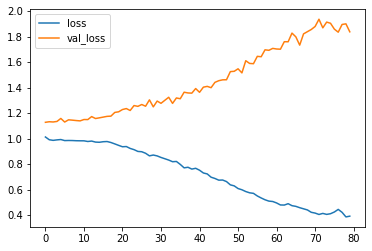

In [0]:
#plot loss
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

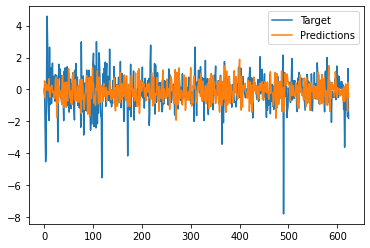

In [0]:
#Multi-Step prediction
validation_predictions=[]
validation_target=Y[-N//2:]

# firts validation unput
last_x = X[-N//2]

while len(validation_predictions)< len(validation_target):
  p = model.predict(last_x.reshape(1,T,1))[0,0]

  #update the predictions list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1]=p


plt.plot(validation_target, label='Target')
plt.plot(validation_predictions, label='Predictions')
plt.legend()


# **Stocks Return Model 3 - Full Data**

In [22]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


In [0]:
# Now turn the full data into numpy arrays

# Now yet in the final 'X' format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Now make the actual dat which will go into the neural network
T=10
D= input_data.shape[1]
N = len(input_data)-T

In [0]:
# normalize the inputs
Ntrain = len(input_data)* 2//3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain +T -1])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain,T,D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T]>0)

In [0]:
# Set X_test and Y_test
X_test = np.zeros((N-Ntrain,T,D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
  t = u + Ntrain
  X_test[u,:,:] = input_data[t:t+T]
  Y_test[u] = (targets[t+T]>0)

In [57]:
X_train.shape[1:]

(10, 5)

In [0]:
#Make the RNN
i=Input(shape=X_train.shape[1:])
x = LSTM(50)(i)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],
)

In [59]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs=300,
    validation_data=(X_test,Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 19ms/step - loss: 0.6955 - accuracy: 0.5006 - val_loss: 0.7090 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5399 - val_loss: 0.6924 - val_accuracy: 0.5171
Epoch 3/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5364 - val_loss: 0.6968 - val_accuracy: 0.4878
Epoch 4/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5399 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 5/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5256 - val_loss: 0.6909 - val_accuracy: 0.5439
Epoch 6/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.4951
Epoch 7/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5459 - val_loss: 0.6921 - val_accuracy: 0.4902
Epoch 8/300


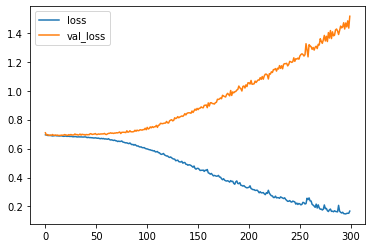

In [60]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

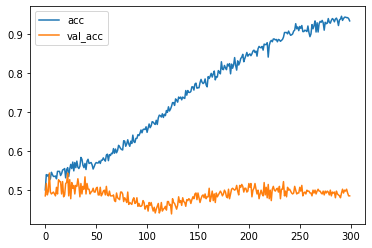

In [61]:
#Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()